# Mask R-CNN - Train on Hake Dataset

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/imatge_upc_ai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
from dataset import DatasetConfig
    
config = DatasetConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [4]:
from dataset import Dataset

In [5]:
# Training dataset
dataset_train = Dataset()
dataset_train.load_dataset('data/hake_train/images/', 'data/hake_train/annotations/hake_coco_train.json')
dataset_train.prepare()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
# Validation dataset
dataset_val = Dataset()
dataset_val.load_dataset('data/hake_val/images/', 'data/hake_val/annotations/hake_coco_val.json')
dataset_val.prepare()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                   "mrcnn_bbox", "mrcnn_mask"])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)
                ])
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads',
            augmentation=augmentation
           )

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# model.train(dataset_train, dataset_train, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=4, 
#             layers="all",
#             augmentation=augmentation
#            )

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Evaluation

In [7]:
from dataset import InferenceConfig

inference_config = InferenceConfig()

bad_testing_samples = [4, 5, 7, 9]

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "../data/models/mask_rcnn_hake_0100.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/imatge_upc_ai/2018-dlcv-team5/Mask_RCNN/../data/models/mask_rcnn_hake_0100.h5


In [8]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 5 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
for image_id in image_ids:
    # Skip wrongly tagged images (ugly, but we could not understand why tags for these images is not working)
    if image_id in bad_testing_samples:
        continue
    # Load image and ground truth data
    print('image id: ' + str(image_id))
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

image id: 2
image id: 0
image id: 10
image id: 8
image id: 2
image id: 2
image id: 8
image id: 0
image id: 0
image id: 1
mAP:  0.6452447593889453


## Detection

In [14]:
def measure_results(results):
    rois = results[0]['rois']
    for i, r in enumerate(rois):
        y1, x1, y2, x2 = r
        w = x2-x1
        h = y2-y1
        ar = w/h
        if ar < 0.9:
            l = h
        if ar > 1.1:
            l = w
        else:
            l = np.sqrt(w**2+h**2)
        print('fish {}: {:.2f}px, {:.2f}cm'.format(i, l, l / 8.29))  # 8.29px per cm

image id: 2
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1280.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:  386.00000  max:  746.00000  int32
gt_mask                  shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  bool


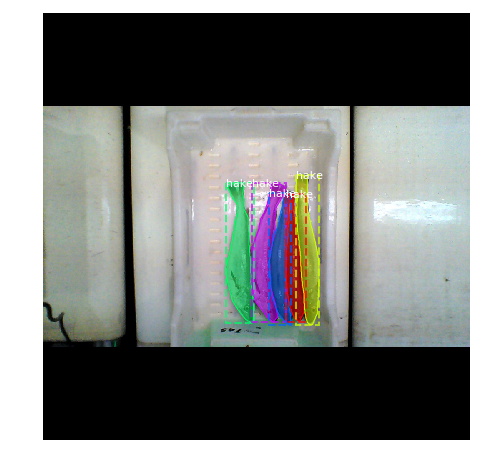

In [32]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
while image_id in bad_testing_samples:
    image_id = random.choice(dataset_val.image_ids)

print('image id: ' + str(image_id))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
fish 0: 321.08px, 38.73cm
fish 1: 329.31px, 39.72cm
fish 2: 301.25px, 36.34cm
fish 3: 313.51px, 37.82cm


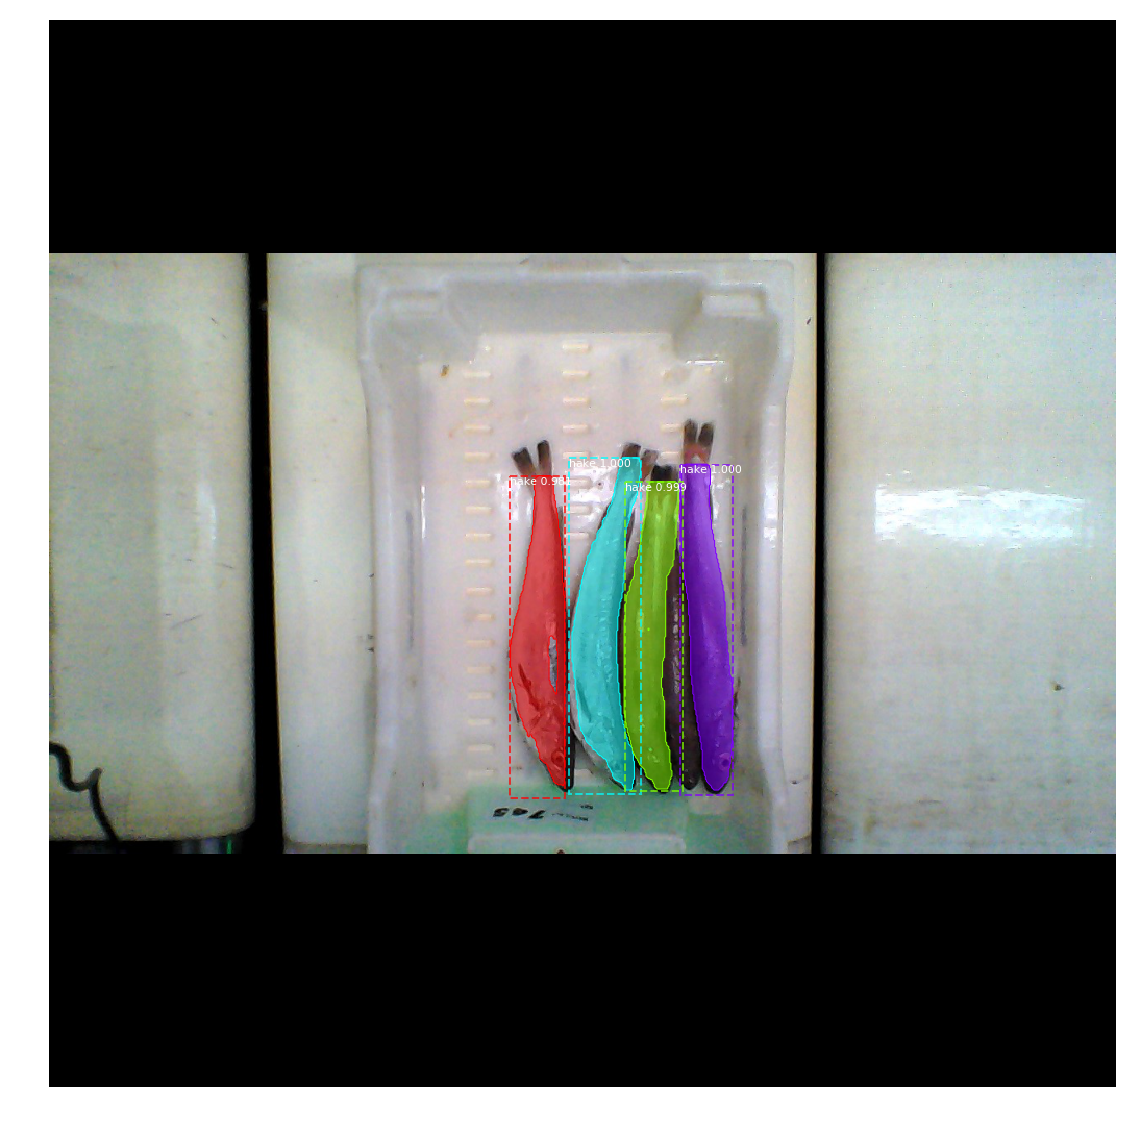

In [33]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(size=20))
measure_results(results)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


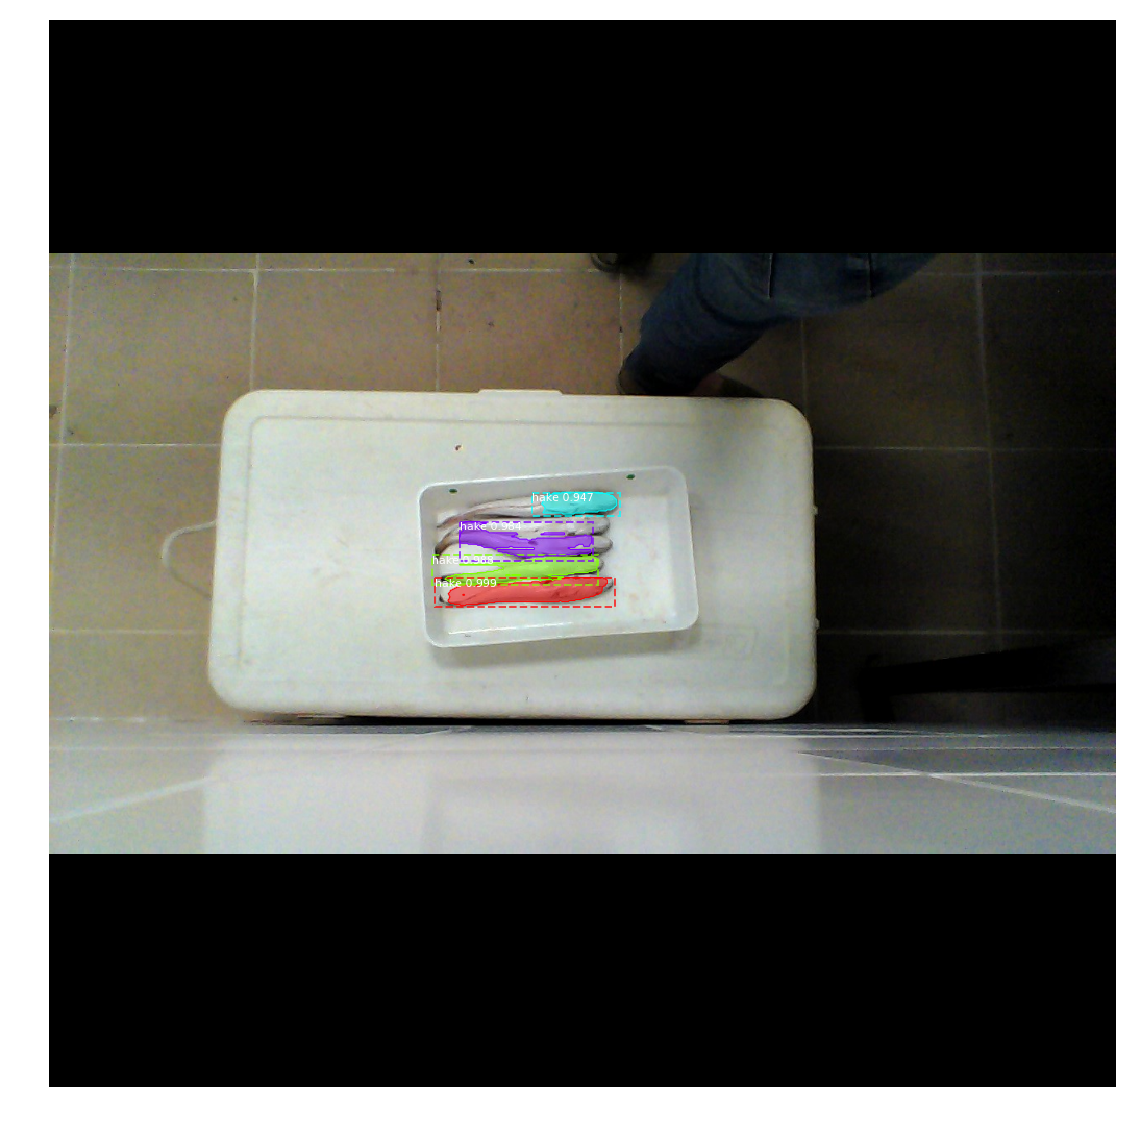

In [11]:
#image = cv2.imread('/home/imatge_upc_ai/data/hake_train/images/caja_blanca_media.jpg')
image = cv2.imread('/home/imatge_upc_ai/2018-dlcv-team5/data/b7.2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE
)

results = model.detect([image], verbose=1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(size=20), show_mask=True)

## Object measure